## Read in v_catch_summary_v2 for marinovich

Based on the HLY2801 Methot Catch Summary notebook, here I plot the georeferenced pie plots of catch.  I've consolidated evrything into the functions in the first cell so the calls can be executed on any year dataset from clams.

I changed from using viridis to definign my own colors:
[0,0,1] # blue
[0,.6,0] # green
[1,0,0] # red
[.5,.5,.1] # brown
[0,0,.4] # dark blue
[.7,0,.7] # purple
[.9,.6,0] # orange
[.9,.6,.8] # pink

In [3]:
import pandas as pd
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import rcParams
from matplotlib.patches import Patch

etopo1name = '../data/etopo1_bedrock.asc'
topo_file = open(etopo1name, 'r')
ncols = int(topo_file.readline().split()[1])
nrows = int(topo_file.readline().split()[1])
xllcorner = float(topo_file.readline().split()[1])
yllcorner = float(topo_file.readline().split()[1])
cellsize = float(topo_file.readline().split()[1])
topo_file.close()
dres = 1
etopo = np.loadtxt(etopo1name, skiprows=5)
etopo[:nrows+1, :] = etopo[nrows+1::-1, :]
etopo = etopo[::dres, ::dres]

# Create longitude and latitude vectors for etopo
lons = np.arange(xllcorner, xllcorner+cellsize*ncols, cellsize)[::dres]
lats = np.arange(yllcorner, yllcorner+cellsize*nrows, cellsize)[::dres]

# Draw etopo1, first for land and then for the ocean, with different colormaps
llevels = np.arange(-500,2251,100) # check etopo.ravel().max()
#lcs = m.contourf(rlons, rlats, etopo, llevels, cmap=cm.terrain)
#olevels = np.arange(-3500,1,100) # check etopo.ravel().min()
olevels1 = [-200,-150,-100,-50,0]
olevels2 = [-2000,-1500,-1000,-500]
olevels3 = [0,10000]
olevels4 = [0]

def draw_pie(ax,ratios=[0.4,0.3,0.3], X=0, Y=0, size = 1000):
    N = len(ratios)
    xy = []
    s =[]
    col=[]
    start = 0.
    ct = 0
    colors =[[0,0.6,0] ,[.9,.6,0] ,[.9,.6,.8],[.7,0,.7],[0,0,1],[.3,.3,.3], [1,0,0] ,[.5,.5,.1] ,[0,0,.4],[.8,.8,.4],[.6,.2,.2],[1,1,1]]
    for ratio in ratios:
        if ratio > 0:
            #col.append(plt.cm.viridis.colors[0::int(len(plt.cm.viridis.colors)/len(marByGroup.group.unique())-1)][1:][ct])
            col.append(colors[ct])
            x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
            y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
            xy1 = list(zip(x,y))
            xy.append(xy1)
            s1 = np.abs(xy1).max()
            s.append(s1)
            start += ratio
        ct+=1
    ct = 0
    for xyi, si in zip(xy,s):
        ax.scatter([X],[Y] , marker=(xyi), s=size*si**2, facecolor=col[ct],transform=ccrs.PlateCarree(), zorder=6,edgecolor="k")
        ct+=1

def pieMap(marEvents, marByGroup, year):
    figure = plt.figure(figsize=(20,20),dpi=300)
    rlons, rlats = (np.meshgrid(lons[:-1],lats[:-1]))
    rcParams['contour.negative_linestyle'] = 'solid'
    ax=plt.subplot(121,projection=ccrs.Mercator())
    rcParams['lines.linewidth'] = .5
    lfill = ax.contourf(rlons, rlats, etopo, olevels3, colors ='grey',transform=ccrs.PlateCarree(),zorder=4)#cmap=cm.ocean)
    cso1 = ax.contour(rlons, rlats, etopo, olevels1, colors ='grey',transform=ccrs.PlateCarree(),zorder=1)#cmap=cm.ocean)
    cso2 = ax.contour(rlons, rlats, etopo, olevels2, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)
    cso4 = ax.contour(rlons, rlats, etopo, olevels4, colors ='k',transform=ccrs.PlateCarree(),zorder=5)#cmap=cm.ocean)
    #ax1.set_extent([-155,-171,59,72.7])

    #ax.plot(marEvents.LONGITUDE,marEvents.LATITUDE,'kx',transform=ccrs.Geodetic(),markersize = 15)
    for event in marByGroup.event.unique():
        X = marEvents.LONGITUDE[marEvents.CLAMS_EVENT_NUMBER == event].values[0]
        Y = marEvents.LATITUDE[marEvents.CLAMS_EVENT_NUMBER == event].values[0]
        draw_pie(ax,np.round([x/sum(marByGroup[marByGroup.event == event].number.values) for x in marByGroup[marByGroup.event == event].number.values],3), X, Y,size=800)

    #ax.plot(mooringRecover.LONGITUDE,mooringRecover.LATITUDE,'.',transform=ccrs.Geodetic(),markersize = 10)
    ax.set_extent([-155,-172,64,73.5])
    #ax.legend(['Vessel Trackline','Bio-Physical Stations','Midwater Trawls'], loc = 7, fontsize='x-large')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-172,-170, -166, -162,-158, -154,-152])
    gl.ylocator = mticker.FixedLocator([57,65,67, 69, 71,73,75])
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size':20}
    gl.ylabel_style = {'size':20}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    #display(Markdown('### Complete Coverage Map'))

    grpLabel = ['Arctic cod', 'Saffron cod','Pacific cod', 'Walleye pollock','Jellyfish', 'Sand lance','Stichaedae', 'Cottidae','Capelin','Herring','Smelts','Other fishes']
    colors =[[0,0.6,0] ,[.9,.6,0] ,[.9,.6,.8],[.7,0,.7],[0,0,1],[.3,.3,.3], [1,0,0] ,[.5,.5,.1] ,[0,0,.4],[.8,.8,.4],[.6,.2,.2],[1,1,1]]

    legendElements = [Patch(facecolor = colors[0], label=grpLabel[0]),
                     Patch(facecolor = colors[1], label=grpLabel[1]),
                     Patch(facecolor = colors[2], label=grpLabel[2]),
                     Patch(facecolor = colors[3], label=grpLabel[3]),
                     Patch(facecolor = colors[4], label=grpLabel[4]),
                     Patch(facecolor = colors[5], label=grpLabel[5]),
                     Patch(facecolor = colors[6], label=grpLabel[6]),
                     Patch(facecolor = colors[7], label=grpLabel[7]),
                     Patch(facecolor = colors[8], label=grpLabel[8]),
                     Patch(facecolor = colors[9], label=grpLabel[9]),
                     Patch(facecolor = colors[10], label=grpLabel[10]),
                     Patch(facecolor = colors[11], label=grpLabel[11])]
                     #Patch(facecolor = plt.cm.viridis.colors[0::int(len(plt.cm.viridis.colors)/len(marByGroup.group.unique())-1)][1:][7], label=grpLabel[7])]
    plt.title(str(year)+' Midwater Catch by Abundance',fontsize=20)
    plt.legend(handles=legendElements,loc='upper right',fontsize=16,bbox_to_anchor=[.97,.55])

    ax=plt.subplot(122,projection=ccrs.Mercator())
    rcParams['lines.linewidth'] = .5
    lfill = ax.contourf(rlons, rlats, etopo, olevels3, colors ='grey',transform=ccrs.PlateCarree(),zorder=4)#cmap=cm.ocean)
    cso1 = ax.contour(rlons, rlats, etopo, olevels1, colors ='grey',transform=ccrs.PlateCarree(),zorder=1)#cmap=cm.ocean)
    cso2 = ax.contour(rlons, rlats, etopo, olevels2, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)
    cso4 = ax.contour(rlons, rlats, etopo, olevels4, colors ='k',transform=ccrs.PlateCarree(),zorder=5)#cmap=cm.ocean)
    #ax1.set_extent([-155,-171,59,72.7])

    #ax.plot(marEvents.LONGITUDE,marEvents.LATITUDE,'kx',transform=ccrs.Geodetic(),markersize = 15)
    for event in marByGroup.event.unique():
        X = marEvents.LONGITUDE[marEvents.CLAMS_EVENT_NUMBER == event].values[0]
        Y = marEvents.LATITUDE[marEvents.CLAMS_EVENT_NUMBER == event].values[0]
        draw_pie(ax,[x/sum(marByGroup[marByGroup.event == event].weight.values) for x in marByGroup[marByGroup.event == event].weight.values], X, Y,size=800)

    #ax.plot(mooringRecover.LONGITUDE,mooringRecover.LATITUDE,'.',transform=ccrs.Geodetic(),markersize = 10)
    ax.set_extent([-155,-172,64,73.5])
    #ax.legend(['Vessel Trackline','Bio-Physical Stations','Midwater Trawls'], loc = 7, fontsize='x-large')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-172,-170, -166, -162,-158, -154,-152])
    gl.ylocator = mticker.FixedLocator([57,65,67, 69, 71,73,75])
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size':20}
    gl.ylabel_style = {'size':20}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    #display(Markdown('### Complete Coverage Map'))
    plt.title(str(year)+' Midwater Catch by Weight',fontsize=20)
    plt.legend(handles=legendElements,loc='upper right',fontsize=16,bbox_to_anchor=[.97,.55])
    plt.show()

def sumByGroup(events,catch):
    marEvents = events[events.GEAR == 'Marinovich']
    catch = catch[(catch.GEAR == 'Marinovich')&(catch.NET_PARTITION == 'Codend')]
    catch['group'] = np.zeros(len(catch.SPECIES_CODE))
    groupNames ={1:'Jellyfish',2:'Sand lance',3:'Stichaedae',4:'Cottidae',5:'Capelin',6:'Herring',7:'Smelts',8:'Other Fishes',
             9:'Invertebrates',21725:'Arctic cod', 21735:'Saffron cod',21720: 'Pacific cod',21740: 'Pollock', 21744:'Age-0 Pollock'}
    for i in range(len(catch.SPECIES_CODE)):
        if (catch.SPECIES_CODE.iloc[i] > 40000) and (catch.SPECIES_CODE.iloc[i] < 50000): # jellyfish
            catch.group.iloc[i] = 1
        elif (catch.SPECIES_CODE.iloc[i] > 21700) and (catch.SPECIES_CODE.iloc[i] < 21750): # gadids
            catch.group.iloc[i] = catch.SPECIES_CODE.iloc[i]
        elif (catch.SPECIES_CODE.iloc[i] >= 20202) and (catch.SPECIES_CODE.iloc[i] <= 20204): # sand lance
            catch.group.iloc[i] = 2
        elif (catch.SPECIES_CODE.iloc[i] >= 23800) and (catch.SPECIES_CODE.iloc[i] <= 23810): # prickleback
            catch.group.iloc[i] = 3
        elif (catch.SPECIES_CODE.iloc[i] >= 21300) and (catch.SPECIES_CODE.iloc[i] <= 21399): # sculpin
            catch.group.iloc[i] = 4
        elif (catch.SPECIES_CODE.iloc[i] == 23041) : # capelin
            catch.group.iloc[i] = 5
        elif (catch.SPECIES_CODE.iloc[i] == 21110) : # herring
            catch.group.iloc[i] = 6
        elif (catch.SPECIES_CODE.iloc[i] == 23055) : # smelts
            catch.group.iloc[i] = 7
        elif (catch.SPECIES_CODE.iloc[i] > 10000) and (catch.SPECIES_CODE.iloc[i] < 30000): # other fishes
            catch.group.iloc[i] = 8
        elif (catch.SPECIES_CODE.iloc[i] == 2) : # otherfishes, specifically larvae
            catch.group.iloc[i] = 8
        elif (catch.SPECIES_CODE.iloc[i] >=1100) and (catch.SPECIES_CODE.iloc[i] < 1200): # other invert new codes
            catch.group.iloc[i] = 9
        elif (catch.SPECIES_CODE.iloc[i] > 60000): # other invert old codes
            catch.group.iloc[i] = 9
    marCatch = catch[['CLAMS_EVENT_NUMBER', 'TOTAL_WEIGHT_IN_HAUL','TOTAL_NUMBER_IN_HAUL','group']]
    marEv = []
    marGrp = []
    marTotWt = []
    marTotCt = []
    for event in marCatch.CLAMS_EVENT_NUMBER.unique():
        for grp in [21725.0, 21735.0, 21720.0, 21744, 1.0, 2.0, 3.0, 4.0, 5.0,6.0,7.0,8.0]: # skipping 9.0 which is inverts
            marEv.append(event)
            marGrp.append(grp)
            if sum(marCatch.TOTAL_WEIGHT_IN_HAUL[(marCatch.CLAMS_EVENT_NUMBER == event) & (marCatch.group == grp)]) > 0:
                marTotCt.append(sum(marCatch.TOTAL_NUMBER_IN_HAUL[(marCatch.CLAMS_EVENT_NUMBER == event) & (marCatch.group == grp)]))
                marTotWt.append(sum(marCatch.TOTAL_WEIGHT_IN_HAUL[(marCatch.CLAMS_EVENT_NUMBER == event) & (marCatch.group == grp)]))
            else:
                marTotCt.append(0)
                marTotWt.append(0)
    marByGroup = pd.DataFrame({'event':marEv,'group':marGrp,'weight':marTotWt,'number':marTotCt })
    return marEvents, marByGroup

<ipython-input-3-cb3d76344160>:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catch['group'] = np.zeros(len(catch.SPECIES_CODE))
C:\Users\rober\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-3-cb3d76344160>:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catch.

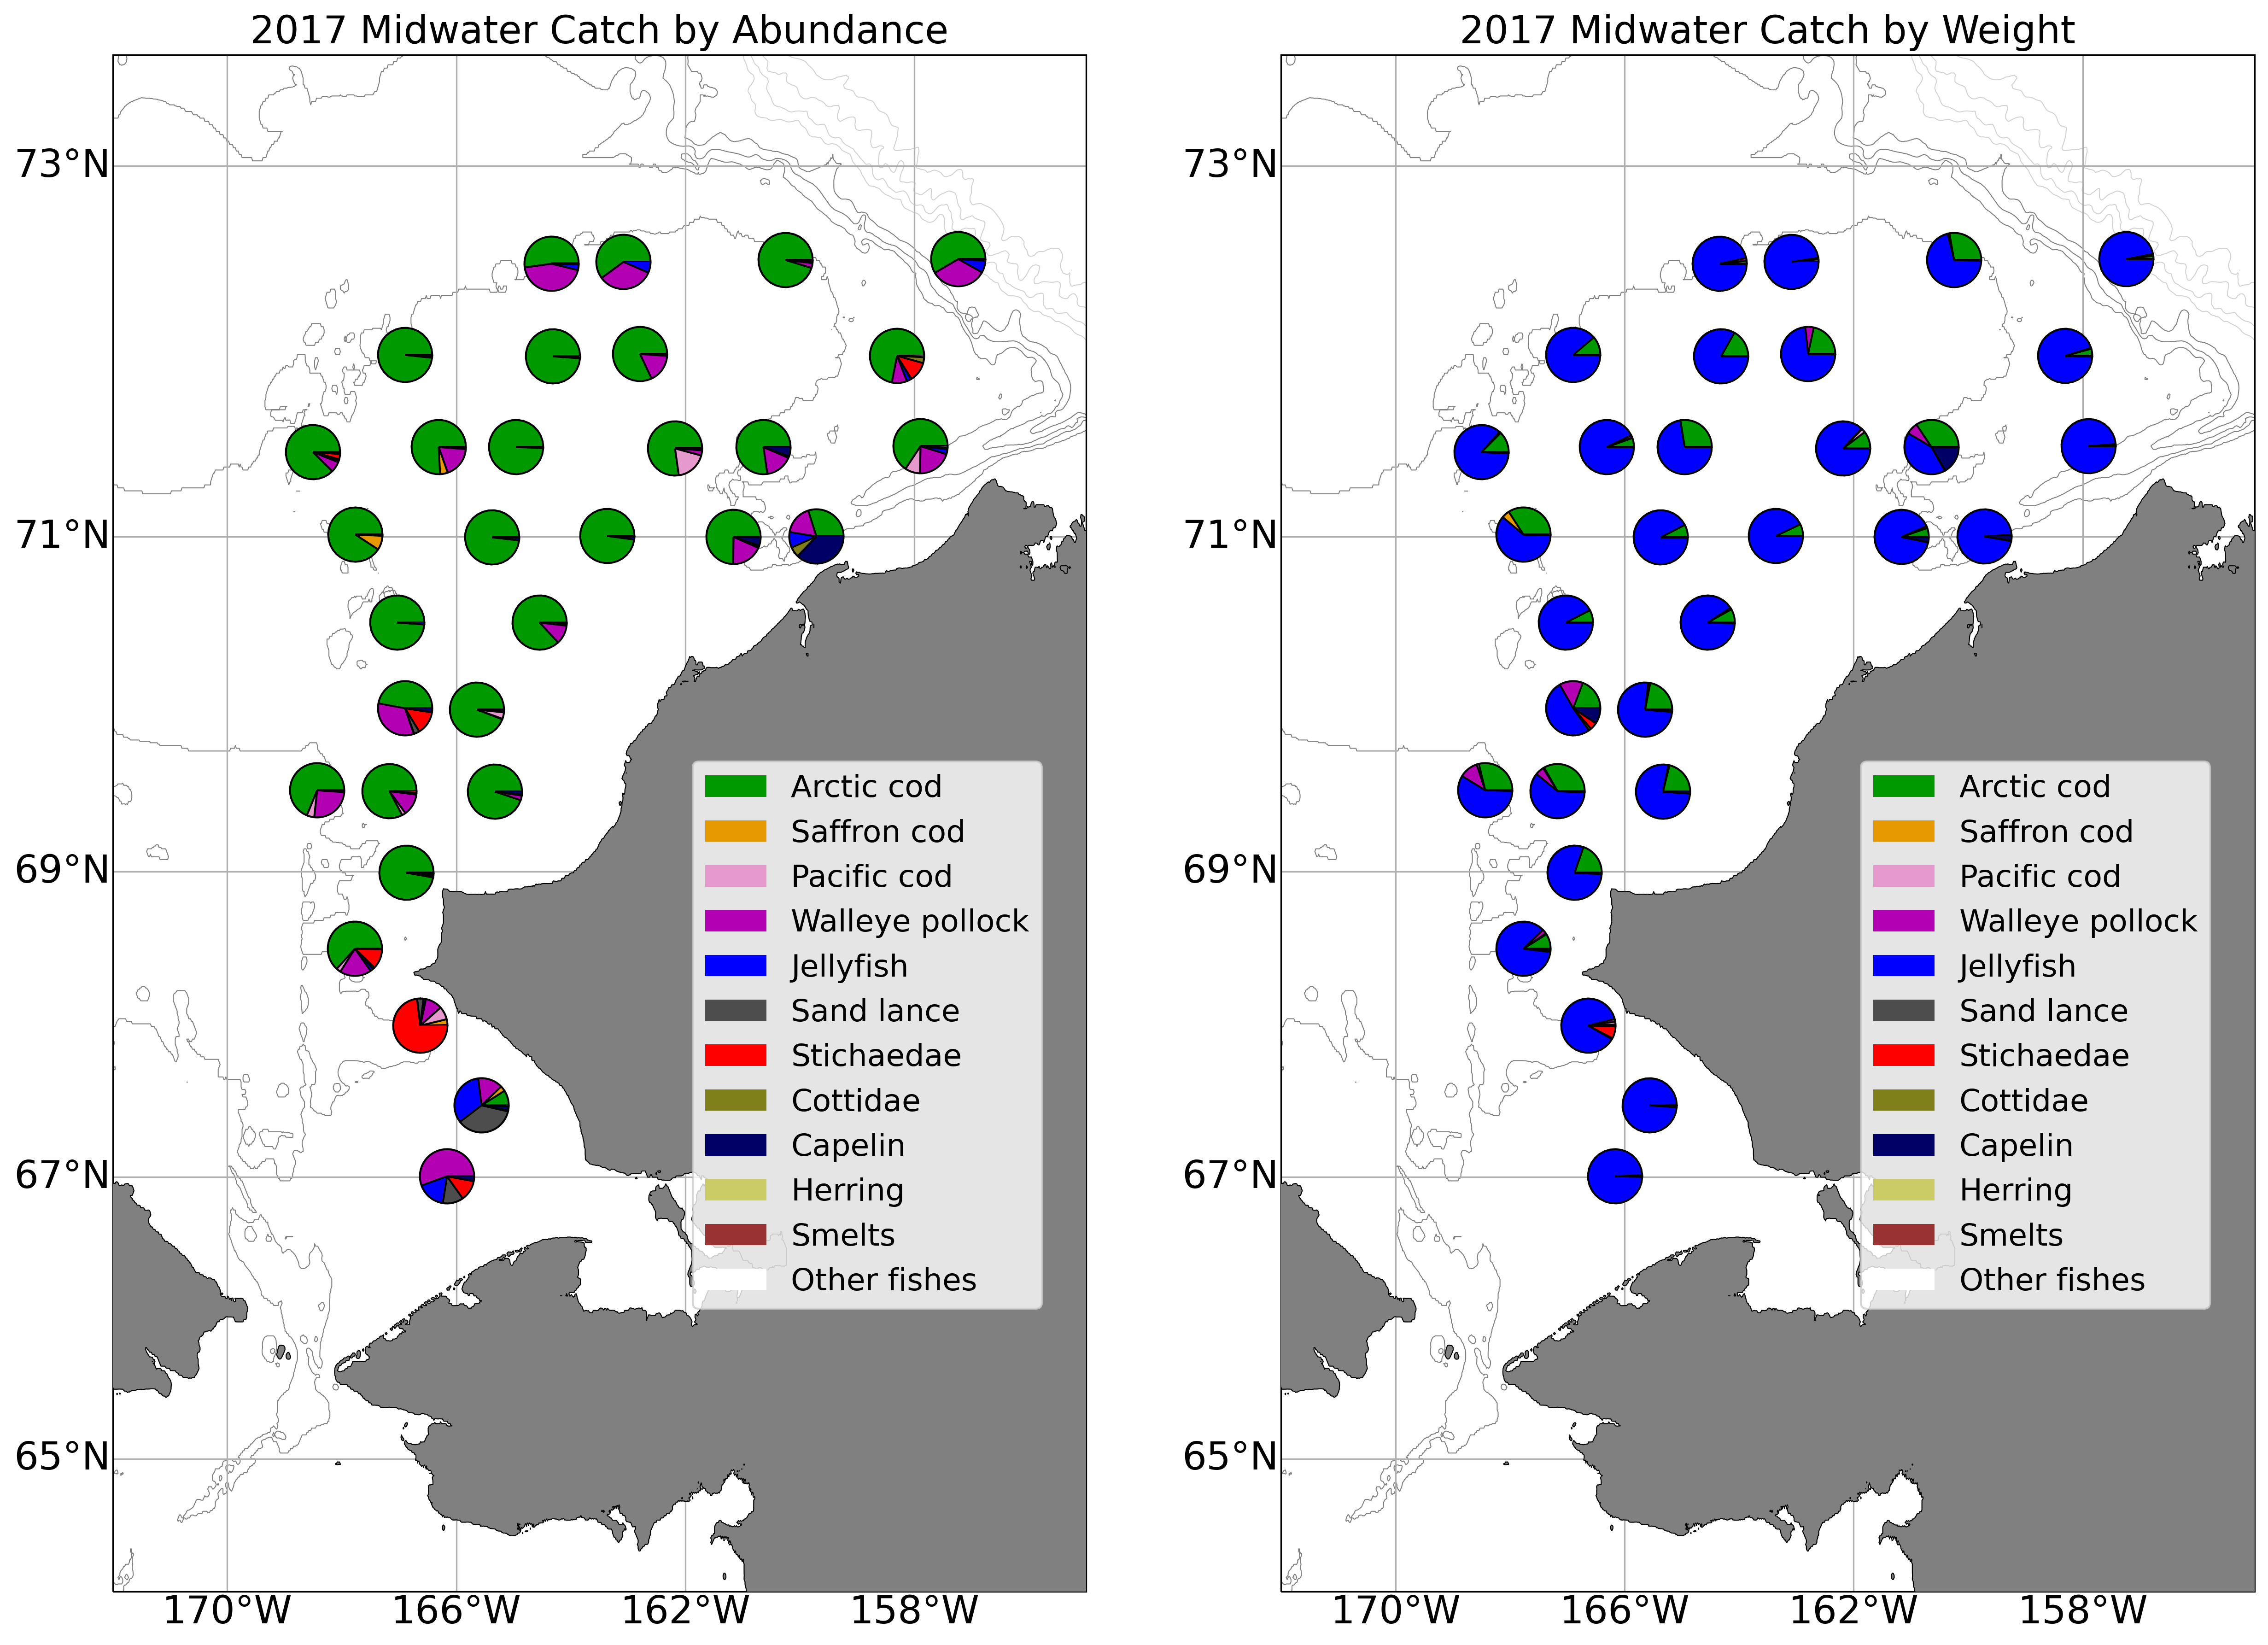

Arctic cod 0.7233214760117171
Saffron cod 0.006026717635840053
Pacific cod 0.014741626649918835
Age-0 Pollock 0.13563780060771935
Jellyfish 0.03147560704421338
Sand lance 0.01809138469433048
Stichaedae 0.04126235808220413
Cottidae 0.009842591247040204
Capelin 0.01883417200842118
Herring 0.0
Other Fishes 0.0
Invertebrates 0.0007662660185951953


In [4]:
catch = pd.read_csv('../data/catchData/2017_2019/catchExport.csv')
events = pd.read_csv('../data/catchData/2017_2019/eventExport.csv')
marEvents, marByGroup = sumByGroup(events[events.SURVEY==201701],catch[catch.SURVEY==201701])
pieMap(marEvents, marByGroup, 2017)
ratio = []
for event in marByGroup.event.unique():
    l=[x/sum(marByGroup[marByGroup.event == event].number.values) for x in marByGroup[marByGroup.event == event].number.values]
    for val in l:
        ratio.append(val)
marByGroup['perAbund'] = ratio
groupNames ={1:'Jellyfish',2:'Sand lance',3:'Stichaedae',4:'Cottidae',5:'Capelin',6:'Herring',7:'Other Fishes',
             8:'Invertebrates',21725:'Arctic cod', 21735:'Saffron cod',21720: 'Pacific cod',21740: 'Pollock', 21744:'Age-0 Pollock'}
for g in marByGroup.group.unique():
    print(groupNames[g],np.mean(marByGroup[marByGroup.group == g].perAbund.values))

In [5]:
marEvents, marByGroup = sumByGroup(events[events.SURVEY==201901],catch[catch.SURVEY==201901])
pieMap(marEvents, marByGroup, 2019)
ratio = []
for event in marByGroup.event.unique():
    l=[x/sum(marByGroup[marByGroup.event == event].number.values) for x in marByGroup[marByGroup.event == event].number.values]
    for val in l:
        ratio.append(val)
marByGroup['perAbund'] = ratio
groupNames ={1:'Jellyfish',2:'Sand lance',3:'Stichaedae',4:'Cottidae',5:'Capelin',6:'Herring',7:'Other Fishes',
             8:'Invertebrates',21725:'Arctic cod', 21735:'Saffron cod',21720: 'Pacific cod',21740: 'Pollock', 21744:'Age-0 Pollock'}
for g in marByGroup.group.unique():
    print(groupNames[g],np.mean(marByGroup[marByGroup.group == g].perAbund.values))

<ipython-input-3-cb3d76344160>:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catch['group'] = np.zeros(len(catch.SPECIES_CODE))
C:\Users\rober\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-3-cb3d76344160>:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catch.

Arctic cod 0.2736243919333862
Saffron cod 0.016464237246525206
Pacific cod 0.0038403404802250228
Age-0 Pollock 0.2227079734131735
Jellyfish 0.19353411481373944
Sand lance 0.17312938444050957
Stichaedae 0.027007488943262336
Cottidae 0.006508149994365934
Capelin 0.007979728070813099
Herring 0.05723437634142771
Other Fishes 0.0087825709870209
Invertebrates 0.009187243335551033


Look at the percent of abundance of the shole survey each group makes up

In [6]:
ratio = []
for event in marByGroup.event.unique():
    l=[x/sum(marByGroup[marByGroup.event == event].number.values) for x in marByGroup[marByGroup.event == event].number.values]
    for val in l:
        ratio.append(val)
marByGroup['perAbund'] = ratio
groupNames ={1:'Jellyfish',2:'Sand lance',3:'Stichaedae',4:'Cottidae',5:'Capelin',6:'Herring',7:'Other Fishes',
             8:'Invertebrates',21725:'Arctic cod', 21735:'Saffron cod',21720: 'Pacific cod',21740: 'Pollock', 21744:'Age-0 Pollock'}
for g in marByGroup.group.unique():
    print(groupNames[g],np.mean(marByGroup[marByGroup.group == g].perAbund.values))

Arctic cod 0.2736243919333862
Saffron cod 0.016464237246525206
Pacific cod 0.0038403404802250228
Age-0 Pollock 0.2227079734131735
Jellyfish 0.19353411481373944
Sand lance 0.17312938444050957
Stichaedae 0.027007488943262336
Cottidae 0.006508149994365934
Capelin 0.007979728070813099
Herring 0.05723437634142771
Other Fishes 0.0087825709870209
Invertebrates 0.009187243335551033


## CPUE

In [7]:
dfEvents = pd.read_csv('../data/catchData/2017_2019/AIERP_EventData.csv')

Arctic cod  0.20339419880155116
Pollock  0.0263540592264076
Arctic cod  0.010812241792565363
Pollock  0.009269913448137386


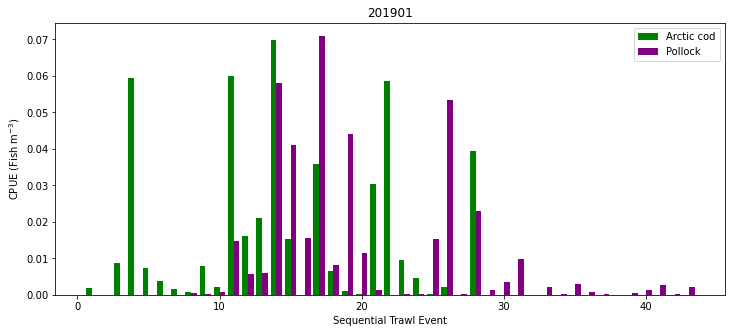

In [144]:
for survey in [201701, 201901]:
    dfPol = catch[(catch.SURVEY == survey) & (catch.GEAR == 'Marinovich') & ((catch.SPECIES_CODE == 21744) | (catch.SPECIES_CODE == 21740))].merge(dfEvents, how='left',  left_on=['SURVEY','CLAMS_EVENT_NUMBER'],   right_on=['SURVEY','EVENT_ID'])
    dfPol['CPUE'] = dfPol.TOTAL_NUMBER_IN_HAUL/dfPol.VOL_FILTERED
    dfPolSum = dfPol.groupby(by=['CLAMS_EVENT_NUMBER']).sum()

    dfA = catch[(catch.SURVEY == survey) & (catch.GEAR == 'Marinovich') & (catch.SPECIES_CODE == 21725)].merge(dfEvents, how='left',  left_on=['SURVEY','CLAMS_EVENT_NUMBER'],   right_on=['SURVEY','EVENT_ID'])
    dfA['CPUE'] = dfA.TOTAL_NUMBER_IN_HAUL/dfA.VOL_FILTERED
    dfASum = dfA.groupby(by=['CLAMS_EVENT_NUMBER']).sum()

    fig, ax = plt.subplots(figsize = (12,5))
    dfs = [dfASum, dfPolSum]
    w = .4
    for df in dfs:
        cpue = []
        for e in dfEvents[dfEvents.SURVEY == survey].EVENT_ID.unique():
            try:
                cpue.append(df[df.index == e].CPUE.values[0])
            except:
                cpue.append(0)
        if 21725 in df.SPECIES_CODE.values:
            ax.bar(np.arange(1,len(dfEvents[dfEvents.SURVEY == survey].EVENT_ID.unique())+1,1)-w/2,cpue,width = w,color = '#008000')
            print('Arctic cod ',np.mean(cpue))
        else:
            ax.bar(np.arange(1,len(dfEvents[dfEvents.SURVEY == survey].EVENT_ID.unique())+1,1)+w/2,cpue,width = w,color = '#800080')
            print('Pollock ',np.mean(cpue))
    plt.legend(['Arctic cod','Pollock'])
    plt.ylabel('CPUE (Fish m$^{-3}$)')
    plt.xlabel('Sequential Trawl Event')
    plt.title(str(survey))